In [5]:
# Импортируем библиотеки для дальнейшей работы
import os
import math
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import catboost as cb
from pathlib import Path
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

!ls data

sample_submission.csv test.csv              train.csv


In [2]:
# Секция констант

seed = 21
p_data = Path('./data')
p_out  = Path('./subs')

In [3]:
# утилиты
def p_print(title: str, data: str):
    print(f'- {title}: {data}')
    
def gen_number():
    l = os.listdir(p_out)
    return len(l)

In [4]:
def clean_dfs(tables):
    for table in tables:
        table.columns = table.columns.str.lower()

# Прочтем данные
df_train = pd.read_csv(p_data/'train.csv')
df_test  = pd.read_csv(p_data/'test.csv')
df_out   = pd.read_csv(p_data/'sample_submission.csv')

clean_dfs([df_train, df_test, df_out])

In [5]:
df_train.head(3)

,id,mean_integrated,sd,ek,skewness,mean_dmsnr_curve,sd_dmsnr_curve,ek_dmsnr_curve,skewness_dmsnr_curve,class
0,0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0


In [6]:
# Как видим, перед нами задача классификации
# при этом все признаки имеют численный вид, что довольно удобно для обработки
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117564 entries, 0 to 117563
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    117564 non-null  int64  
 1   mean_integrated       117564 non-null  float64
 2   sd                    117564 non-null  float64
 3   ek                    117564 non-null  float64
 4   skewness              117564 non-null  float64
 5   mean_dmsnr_curve      117564 non-null  float64
 6   sd_dmsnr_curve        117564 non-null  float64
 7   ek_dmsnr_curve        117564 non-null  float64
 8   skewness_dmsnr_curve  117564 non-null  float64
 9   class                 117564 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 9.0 MB


In [7]:
# И даже нет пропусков... 
df_train.isna().sum()

id                      0
mean_integrated         0
sd                      0
ek                      0
skewness                0
mean_dmsnr_curve        0
sd_dmsnr_curve          0
ek_dmsnr_curve          0
skewness_dmsnr_curve    0
class                   0
dtype: int64

## Краткое описание полей датасета:
- Mean_Integrated: Среднее по наблюдениям
- SD: Стандартное отклонение в наблюдениях
- EK: Численная характеристика остроты пика распределения результатов наблюдений
- Skewness: мера ассиметричности вероятностого распределения результатов наблюдений

#### Какие-то физические волновые чертовщины
- Mean _ DMSNR _ Curve: Mean of DM SNR CURVE of Observations
- SD _ DMSNR _ Curve: Standard deviation of DM SNR CURVE of Observations
- EK _ DMSNR _ Curve: Excess kurtosis of DM SNR CURVE of Observations
- Skewness _ DMSNR _ Curve: Skewness of DM SNR CURVE of Observations

DM SNR CURVE:
Radio waves emitted from pulsars reach earth after traveling long distances in space which is filled with free electrons. The important point is that pulsars emit a wide range of frequencies, and the amount by which the electrons slow down the wave depends on the frequency. Waves with higher frequency are sowed down less as compared to waves with higher frequency. It means dispersion.

Класса всего два: 0 - не пульсар, 1 - пульсар.

In [8]:
# Посмотрим на наличие потенциальных выбросов
# Распределение целевой переменной нас конечно же не интересует!
df_train.iloc[:, :-1].describe().loc[['std', 'mean', '50%', 'min', 'max'], :]

# - ek mean~std x median?
# skewness???

,id,mean_integrated,sd,ek,skewness,mean_dmsnr_curve,sd_dmsnr_curve,ek_dmsnr_curve,skewness_dmsnr_curve
std,33937.947861,24.906474,6.102941,1.127093,6.515466,26.719946,20.041937,3.840980,79.962110
mean,58781.500000,111.248300,46.713535,0.503498,1.886385,11.962921,26.190678,8.037488,93.881076
50%,58781.500000,116.664062,47.478932,0.186498,0.091720,2.808528,18.164924,8.442883,83.421375
min,0.000000,6.054688,24.783273,-1.730782,-1.791886,0.213211,7.370432,-2.597872,-1.976976
max,117563.000000,189.367188,93.602933,7.879628,65.385974,217.371238,109.890785,34.539844,1191.000837


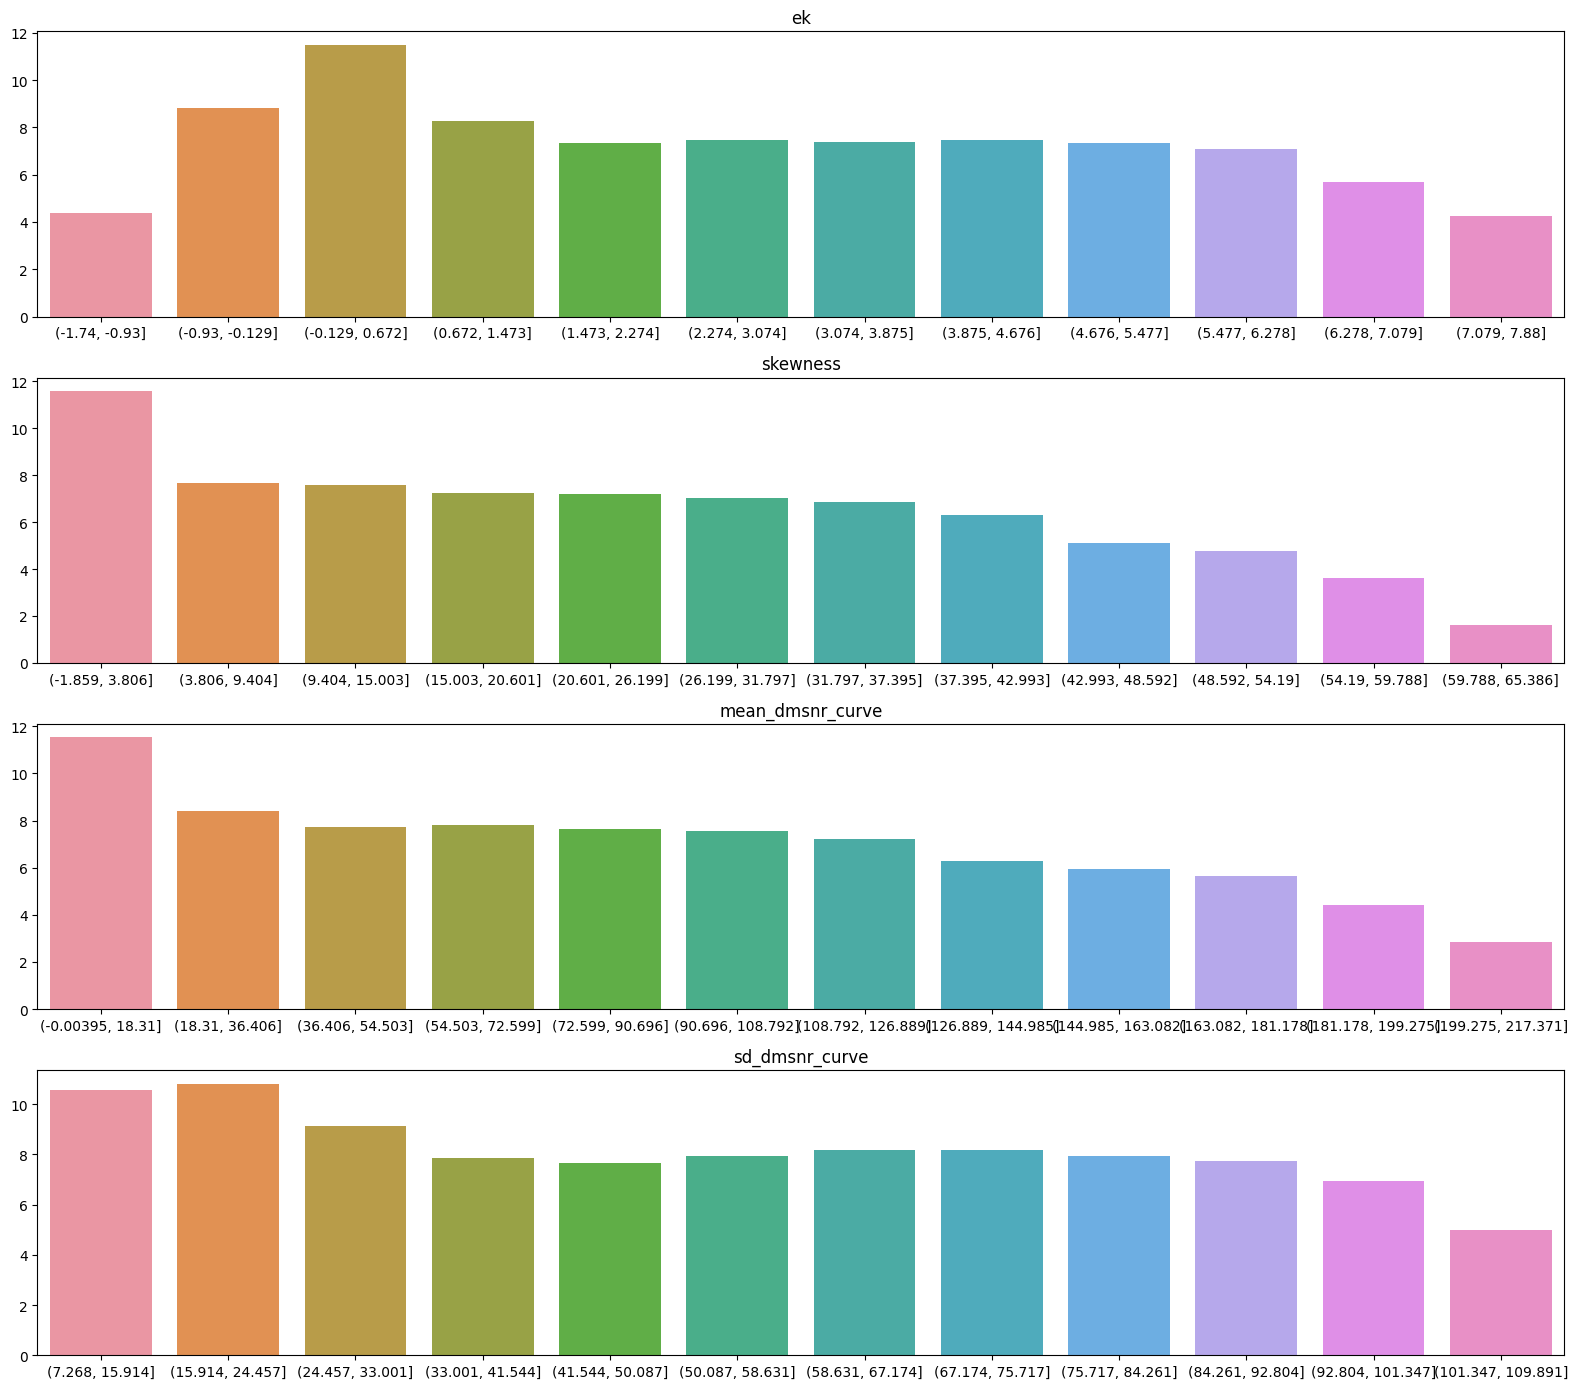

In [9]:
# Посмотрим на распределение данных признаков
f_strange_distribution = ['ek', 'skewness', 'mean_dmsnr_curve', 'sd_dmsnr_curve']

fig, axs = plt.subplots(4, 1, figsize=(16, 14))

for i in range(4):
    curr_column = f_strange_distribution[i]
    
    features = pd.cut(df_train[curr_column], 12).value_counts()
    log_features = np.log(features)
    # Количество записей большое, поэтому демонстрировать будем по логарифму
    
    sns.barplot(x=log_features.index, y=log_features.values, ax=axs[i])
    axs[i].set_title(curr_column)
    
plt.tight_layout()

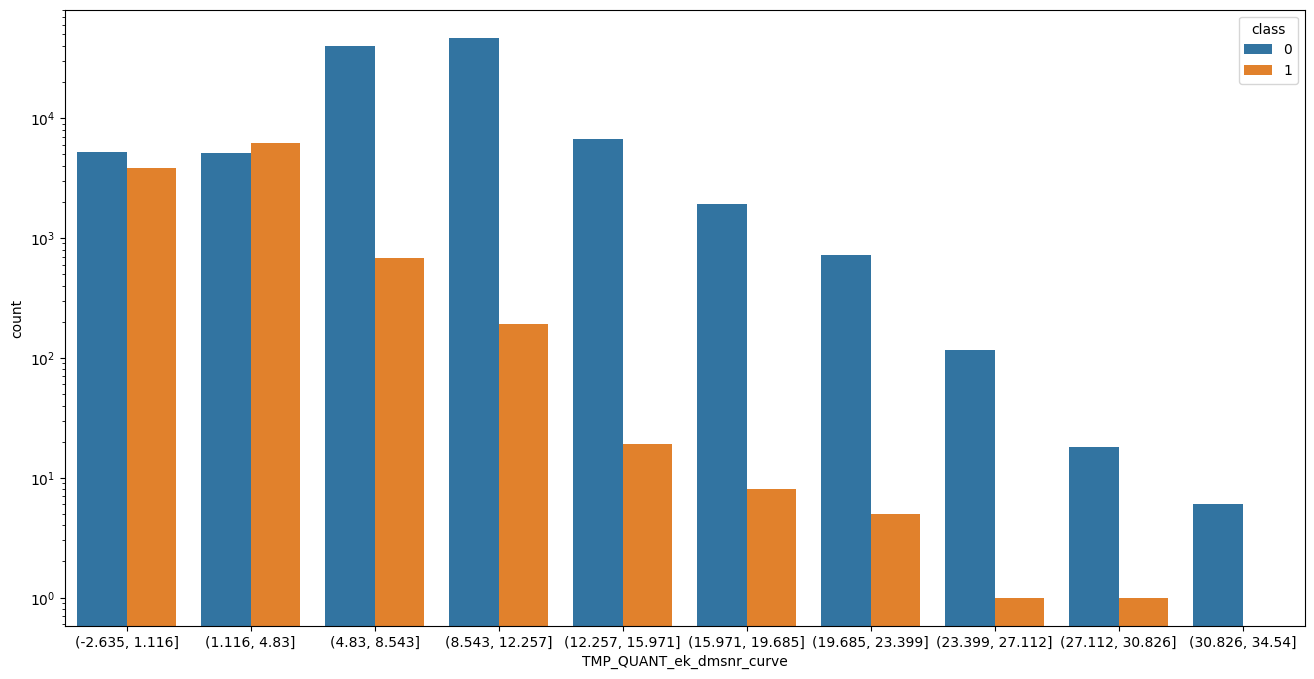

In [10]:
# Случайно выяснил, что ek_dmsnr_curve сильно влияет на целевую переменную.
# Может график ее распределения поможет определить выбросы?
df_analysis = df_train.copy(True)
df_analysis['TMP_QUANT_ek_dmsnr_curve'] = pd.cut(df_train['ek_dmsnr_curve'], 10)


fig, ax = plt.subplots(figsize=(16, 8))
#a_data = df_analysis['TMP_QUANT_ek_dmsnr_curve'].value_counts()

g = sns.countplot(df_analysis, x='TMP_QUANT_ek_dmsnr_curve', hue='class', ax=ax)
g.set_yscale('log')

plt.show()

#### Даже и говорить не нужно о том, насколько важную роль играет этот признак для определения целевой переменной: чем меньше значение эксцесса для измерений dmsnr curve, тем выше шанс, что наша звезда - пульсар!

<Axes: >

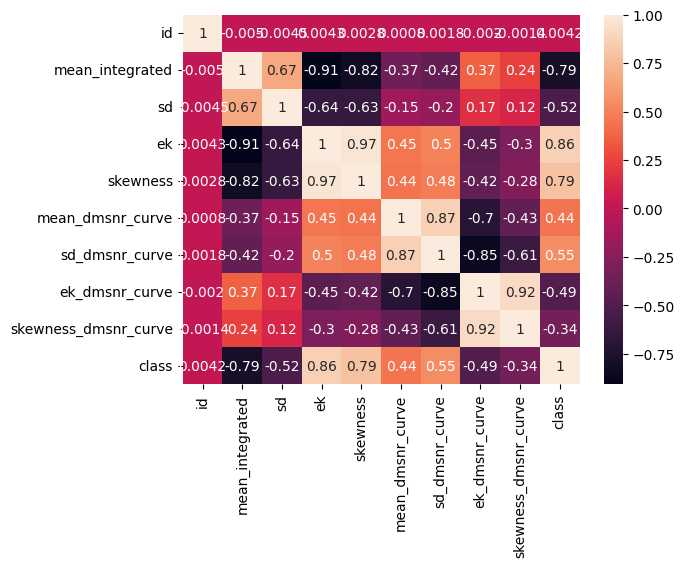

In [11]:
# Подтвердим проверку идеи просмотром таблицы корреляции!
# Кажется, что все признаки сильно связаны с целевой переменной
sns.heatmap(df_train.corr(), annot=True)

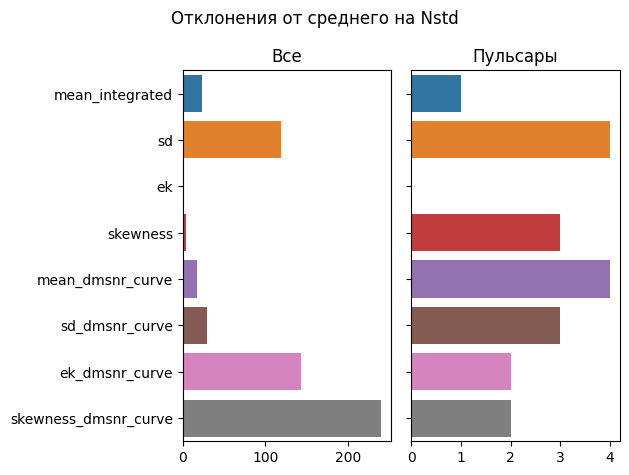

In [12]:
# Эксперимент с проверкой отклонений


deviation_coefs = [
    2.5, 3.6, 6.7, 9,
    7, 4, 4, 6,
]

over_stds  = df_train.iloc[:, 1:-1].mean() + df_train.iloc[:, 1:-1].std() * deviation_coefs
vals_below_std_count = []
pulsars_below_std_count = []
pulsar_indexes = []

for c, shift in zip(over_stds.index, over_stds.values):
    tmp = df_train.iloc[:, 1:].query(f'{c} > {shift}')
    
    vals_below_std_count.append(len(tmp))
    pulsars_below_std_count.append((tmp['class'] == 1).sum())
    pulsar_indexes.append((tmp['class'] == 1).index)

# Все эти сущности с отклонениями больше чем на N std похожи на выбросы в данных
fig, axs = plt.subplots(1, 2, sharey=True)

g = sns.barplot(y=over_stds.index, x=vals_below_std_count, ax=axs[0])
g.set_title('Все')

g = sns.barplot(y=over_stds.index, x=pulsars_below_std_count, ax=axs[1])
g.set_title('Пульсары')

plt.suptitle('Отклонения от среднего на Nstd')
plt.tight_layout()
plt.show()

In [13]:
# Проверим качество модели на данных без такого рода отклонений
deviation_indexes = np.unique(list(itertools.chain(*pulsar_indexes)))
df_train2 = df_train.copy(True)
df_train2.drop(deviation_indexes, inplace=True)

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def prepare_data(df, test_size=0.23, is_train=True):
    if is_train:
        df_train = df.copy()

        # нормализуем
        scaler = StandardScaler()
        df_train_X_scaled = scaler.fit_transform(df_train.iloc[:, 1:-1])
        df_train.iloc[:, 1:-1] = df_train_X_scaled

        # поделим
        X_train, X_test, y_train, y_test = train_test_split(
            df_train.iloc[:, :-1], df_train.iloc[:, -1],
            random_state=seed, test_size=test_size
    
        )
        return X_train, X_test, y_train, y_test

    else:
        df_test = df.copy()
        scaler = StandardScaler()
        df_test.iloc[:, 1:] = scaler.fit_transform(df_test.iloc[:, 1:])
        return df_test


In [15]:
X_train, X_test, y_train, y_test = prepare_data(df_train)
test_out = prepare_data(df_test, is_train=False)

In [16]:
clf = cb.CatBoostClassifier(verbose=False)
clf.fit(X_train.iloc[:, 1:], y_train.values)
y_pred = clf.predict_proba(X_test)
log_loss(y_test, y_pred[:, 1])

0.030460524346051593

In [17]:
y_pred[:, 1]

array([6.76412193e-04, 9.52430644e-06, 1.36751344e-04, ...,
       6.66612288e-04, 1.22962914e-03, 1.63646504e-05])

In [18]:
# sub
y_pred = clf.predict_proba(test_out.iloc[:, 1:])
df_test['class'] = y_pred[:, 1]
df_test.loc[:, ['id', 'class']].to_csv(p_out/f't1_{gen_number()}.csv', index=False)